In [1]:
import io
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageGrab

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
import torchvision.models as models

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if torch.cuda.is_available():
  torch.set_default_device('cuda')
  device = 'cuda'
else:
  device = 'cpu'

TODO
- cropping??
- gradcam understanding

In [3]:
fromfile = False
if fromfile:
    df = pd.read_parquet('dataset1', engine='fastparquet')
    shuffled_df = df[['image.bytes', 'country_iso_alpha2']].sample(frac=1)
    shuffled_df.to_parquet('shuffled_data.parquet')
df = pd.read_parquet('shuffled_data.parquet', engine='fastparquet')

In [4]:
cntry_str = np.unique(df['country_iso_alpha2'].values); cntry_str.sort()
cntry_dict = dict(zip(cntry_str, range(cntry_str.shape[0])))
with open('cntry_codes_to_names.txt') as f: 
    country_codes = json.loads(f.read())
num_classes = cntry_str.shape[0]

In [5]:
class ParquetImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(io.BytesIO(row['image.bytes']))
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), np.searchsorted(cntry_str, row['country_iso_alpha2'])

class JpgImageDataset(torch.utils.data.Dataset):
    def __init__(self, lst, transforms=None):
        self.lst = lst
        self.transforms = transforms

    def __len__(self):
        return len(self.lst)

    def __getitem__(self, idx):
        row = self.lst[idx]
        image = Image.open(row[0])
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), row[1]

generator, dataset, dataloader

In [6]:
transf = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

parquet_dataset = ParquetImageDataset(df, transforms.Compose([transforms.RandomCrop((512, 1187)), transf]))

imfolder = torchvision.datasets.ImageFolder.make_dataset(directory="dataset2", is_valid_file=(lambda s: Image.open(s).size == (1536, 662)), class_to_idx=cntry_dict)
jpg_dataset = JpgImageDataset(imfolder, transforms=transforms.Compose([transforms.Resize(512), transf]))

big_dataset = torch.utils.data.ConcatDataset([jpg_dataset, parquet_dataset])

# datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [0.7, 0.2, 0.1], generator=torch.Generator('cuda'))

# dataloaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, generator=torch.Generator('cuda'))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=True, generator=torch.Generator('cuda'))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True, generator=torch.Generator('cuda'))

In [7]:
def visual(loader, n, model=None):
    for  images, labels in loader:
        if n <= batch_size:
            for i in range(n):
                print(f'label: {country_codes[cntry_str[labels[i]]]}')
                if model != None:
                        print(f'guess: {country_codes[cntry_str[torch.argmax(model(images[i][None, :])).item()]]}')
                plt.figure(figsize = (50,2))
                plt.imshow(images[i].to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)
                plt.show()
        else:
            print(f"Number of images ({n}) should be less than or equal to batch size ({batch_size})")
        break # next(iter(loader)) esetén "list object is not callable" error jön

Dataset size: 34427

-Examples:
label: Ireland


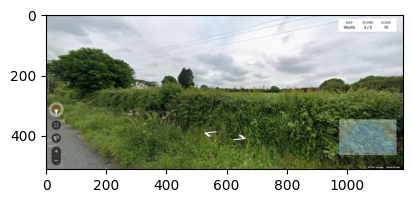

In [8]:
print(f"Dataset size: {len(big_dataset)}\n\n-Examples:")
visual(val_dataloader, 1)

model

In [31]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(nn.Linear(num_ftrs, 1000),
                                         nn.Linear(1000, 1000),
                                         nn.Linear(1000, num_classes))
                                         #nn.Linear(400, num_classes))
        #for param in self.backbone.parameters():
        #    param.requires_grad = False
        #for param in self.backbone.fc.parameters():
        #    param.requires_grad = True
        #for param in self.backbone.layer4.parameters():
        #    param.requires_grad = True
        self.backbone.

    def forward(self, x):
        return self.backbone(x)
    
    @torch.no_grad()
    def calc_loss_and_acc(self, dataloader, n, criterion=nn.CrossEntropyLoss()):
        self.eval()

        loss_sum = 0.0
        acc_sum = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = self(inputs)
            
            loss_sum += criterion(outputs, targets).item()
            acc_sum += torch.sum(torch.argmax(outputs, 1) == targets)
            if i >= n: break
        return loss_sum / n, acc_sum / (n * batch_size)

    def get_loss(self, batch, criterion=nn.CrossEntropyLoss()):
        inputs, labels = batch
        return criterion(self(inputs), labels)



In [32]:
model2 = Model().to(device)
torchsummary.summary(model2, (3, 512, 1187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 594]           9,408
       BatchNorm2d-2         [-1, 64, 256, 594]             128
              ReLU-3         [-1, 64, 256, 594]               0
         MaxPool2d-4         [-1, 64, 128, 297]               0
            Conv2d-5         [-1, 64, 128, 297]           4,096
       BatchNorm2d-6         [-1, 64, 128, 297]             128
              ReLU-7         [-1, 64, 128, 297]               0
            Conv2d-8         [-1, 64, 128, 297]          36,864
       BatchNorm2d-9         [-1, 64, 128, 297]             128
             ReLU-10         [-1, 64, 128, 297]               0
           Conv2d-11        [-1, 256, 128, 297]          16,384
      BatchNorm2d-12        [-1, 256, 128, 297]             512
           Conv2d-13        [-1, 256, 128, 297]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [10]:
model = Model().to(device)

In [12]:
torchsummary.summary(model, (3, 512, 1187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 594]           9,408
       BatchNorm2d-2         [-1, 64, 256, 594]             128
              ReLU-3         [-1, 64, 256, 594]               0
         MaxPool2d-4         [-1, 64, 128, 297]               0
            Conv2d-5         [-1, 64, 128, 297]           4,096
       BatchNorm2d-6         [-1, 64, 128, 297]             128
              ReLU-7         [-1, 64, 128, 297]               0
            Conv2d-8         [-1, 64, 128, 297]          36,864
       BatchNorm2d-9         [-1, 64, 128, 297]             128
             ReLU-10         [-1, 64, 128, 297]               0
           Conv2d-11        [-1, 256, 128, 297]          16,384
      BatchNorm2d-12        [-1, 256, 128, 297]             512
           Conv2d-13        [-1, 256, 128, 297]          16,384
      BatchNorm2d-14        [-1, 256, 1

Training

In [13]:
#for param in model.backbone.parameters():
#    param.requires_grad = True

In [14]:
tr_losses = []
val_losses = []

In [22]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)

In [23]:
for epoch in range(10):
  for i, batch in enumerate(train_dataloader):

    model.train()
    optimizer.zero_grad()

    train_loss = model.get_loss(batch)
    train_loss.backward()
    optimizer.step()

    if i % 40 == 0:
      tr_losses.append(train_loss.item())
      val_loss, acc = model.calc_loss_and_acc(val_dataloader, 10)
      val_losses.append(val_loss)
      print(f"epoch {epoch}, step {i}: train loss {train_loss:.4f}, val loss: {val_loss:.4f}, val acc: {acc:.4f}")


epoch 0, step 0: train loss 1.7394, val loss: 2.0990, val acc: 0.5188
epoch 0, step 40: train loss 1.5374, val loss: 2.2211, val acc: 0.5000
epoch 0, step 80: train loss 2.2936, val loss: 2.1986, val acc: 0.5188


KeyboardInterrupt: 

In [ ]:
#model2 = Model().to(device)
#model2.load_state_dict(torch.load("models/rn50_2_overfitted"))
#model2.eval()

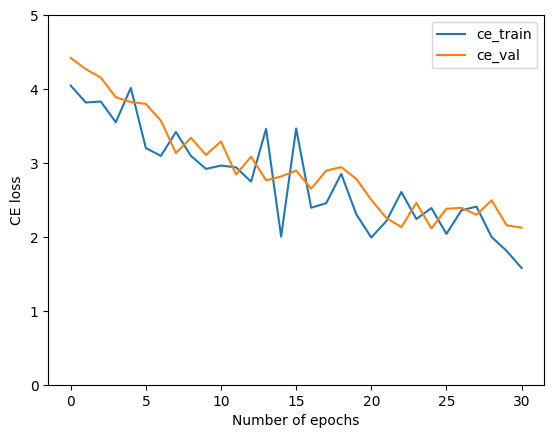

In [19]:
# loss plot
plt.plot(tr_losses, label="ce_train")
plt.plot(val_losses, label="ce_val")
plt.xlabel("Number of epochs")
plt.ylabel("CE loss")
plt.ylim(0,5)
plt.legend()
plt.show()

In [ ]:
model.calc_loss_and_acc(test_dataloader, len(test_dataset) / batch_size)

(1.800658106319022, tensor(0.5003, device='cuda:0'))

In [ ]:
targets_long = torch.tensor([])
preds = torch.tensor([])
with torch.no_grad():
    model.eval()
    j = 0

    sum = 0
    count = 0
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        sum += torch.sum(torch.argmax(outputs, 1) == targets)
        count += targets.shape[0]
        targets_long = torch.cat((targets_long, targets))
        preds = torch.cat((preds, torch.argmax(outputs, 1)))
        j += 1
        if j > 50:
            break
        model.calc_loss_and_acc(test_dataloader, test_dataset / batch_size)
    print(sum / count)


In [ ]:
targets_long = F.one_hot(input=targets_long.long(), num_classes=56).transpose(0,1)[:, None, :]
preds = F.one_hot(preds.long()).transpose(0,1)[None, ...]
print(f'{targets_long.shape} {preds.shape}')
# targets: (56, 1, n)
# preds:  (1, 56, n)

NameError: name 'targets_long' is not defined

In [ ]:
hm = torch.sum(torch.logical_and(targets_long, preds), axis=2).to('cpu')
hm = hm / torch.sum(hm, dim=1, keepdim=True)
plt.figure(figsize = (8, 8))
plt.imshow(hm, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.locator_params(axis='both', integer=True)

plt.show()

In [ ]:
t = targets_long.long().argmax(0)[0]
plt.hist(t.to('cpu'), bins=56)

In [ ]:
visual(test_dataloader, 10, model)
,

In [ ]:
#torch.save(model.state_dict(), "models/rn50_4")

In [ ]:
while True:
    screen = ImageGrab.grab()
    tr = transforms.Compose([transforms.CenterCrop((800,1800)), transforms.Resize((512, 1187)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    screen_tr = tr(screen).to(device)
    with torch.no_grad():
        guess = F.softmax(dim=1, input=model(screen_tr[None, :]))
    print(f'Guess: {country_codes[cntry_str[torch.argmax(guess)]]} {torch.max(guess)*100:.1f}%  --  Hungary: {guess[0,25]*100:.1f}%')
    #plt.imshow(screen_tr.to('cpu').transpose(0,2).transpose(0,1) *0.5 + 0.5); break
    time.sleep(2)

In [ ]:
testimage = Image.open("osgyan.png")
tr = transforms.Compose([transforms.Resize((512, 1187)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testimage_tr = tr(testimage).to(device)
with torch.no_grad():
    guess = F.softmax(dim=1, input=model2(testimage_tr[None, :]))
print(country_codes[cntry_str[torch.argmax(guess)]])
print(guess.max())
testimage.close()

In [ ]:
plt.imshow(testimage_tr.to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)
plt.figure(figsize=(20,6))
#plt.bar(cntry_str, guess.to('cpu')[0], )

In [ ]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [ ]:
model2.eval()
backward_hook = model2.backbone.layer4[-3].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model2.backbone.layer4[-3].register_forward_hook(forward_hook, prepend=False)

In [ ]:
im = testimage_tr[None, :]
model2(im)[0, 25].backward()

In [ ]:
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

In [ ]:
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

In [ ]:
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.to('cpu').detach())

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL
# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(im[0].to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmap.detach(), mode='F').resize((1187, 512), resample=PIL.Image.BICUBIC) 

# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8) 

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay, alpha=0.3, interpolation='nearest')

# Show the plot
plt.show()